# Defy Tradition, Save the World

This is one of the Jupyter notebooks I used in my preparation of *[Probably Overthinking It: How to Use Data to Answer Questions, Avoid Statistical Traps, and Make Better Decisions](https://greenteapress.com/wp/probably-overthinking-it)*, University of Chicago Press, 2023.

Before you read these notebooks, please keep in mind:

* There is some explanatory text here, but some of the examples will not make sense until you have read the corresponding chapter in the book.

* While preparing these notebooks, I made some changes to improve the readability of the code. There might be small differences between what appears in the book and what you get when you run the code.

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ProbablyOverthinkingIt/blob/book/notebooks/preston.ipynb).

In [29]:
# Install empiricaldist if we don't already have it

try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

In [30]:
# download utils.py

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
        
download("https://github.com/AllenDowney/ProbablyOverthinkingIt/raw/book/notebooks/utils.py")

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Set the random seed so we get the same results every time
np.random.seed(17)

Suppose you are the ruler of a small country where the population is growing quickly.
Your advisers warn you that unless this growth slows down, the population will exceed the capacity of the farms and the peasants will starve.

The Royal Demographer informs you that the average family size is currently 3; that is, each woman in the kingdom bears three children, on average.
He explains that the replacement level is close to 2, so if family sizes decrease by one, the population will level off at a sustainable size.

One of your advisors asks: "What if we make a new law that says every woman has to have fewer children than her mother?"

It sounds promising.
As a benevolent despot, you are reluctant to restrict your subjects' reproductive freedom, but it seems like such a policy could be effective at reducing family size with minimal imposition.

"Make it so," you say.

Twenty-five years later, you summon the Royal Demographer to find out how things are going.

"Your Highness," they say, "I have good news and bad news. The good news is that adherence to the new law has been perfect. Since it was put into effect, every woman in the kingdom has had fewer children than her mother."

"That's amazing," you say. "What's the bad news?"

"The bad news is that the average family size has increased from 3.0 to 3.3, so the population is growing faster than before, and we are running out of food."

"How is that possible?" you ask. 
"If every woman has fewer children than her mother, family sizes have to get smaller, and population growth has to slow down."

Actually, that's not true.

In 1976, Samuel Preston, a demographer at the University of Washington, published a paper that presents three surprising phenomena.

The first is the relationship between two measurements of family size: what we get if we ask women how many children they have, and what we get if we ask people how many children their mother had.
In general, the average family size is smaller if ask women about their children, and larger if we ask children about their mothers.

The second phenomenon is related to changes in American family sizes during the 20th century.
Suppose you compare family sizes during the Great Depression (roughly the 1930s) and the Baby Boom (1946-64).
If you survey women who bore children during these periods, the average family was bigger during the Baby Boom. 
But if you ask their children how big their families were, the average was bigger during the Depression.

The third phenomenon is what we learned in your imaginary kingdom, which I will call Preston's Paradox: Even if every woman has fewer children than her mother, family sizes can get bigger, on average.

To see how that's possible, we'll start with the two measurements of family size.

In [32]:
# Read the Census data
# Originally from https://www2.census.gov/programs-surveys/demo/tables/fertility/time-series/his-cps/h2.xlsx

download(
    "https://github.com/AllenDowney/ProbablyOverthinkingIt/raw/book/data/h2.xlsx"
)

In [33]:
rename_dict = {
    "Unnamed: 0": "Year",
    "Unnamed: 1": "Total",
    "Unnamed: 11": "Rate per 1000",
}

df = pd.read_excel("h2.xlsx", skiprows=6)
del df["Unnamed: 7"]
df.rename(columns=rename_dict, inplace=True)
df.head()

,Year,Total,Total,None,One,Two,Three,Four,Five and six,Seven or more,Rate per 1000
0,All Marital Statuses,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,.Women 45 to 50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,.2018,12524,100,15.4,19.8,35.4,17.3,7.4,3.6,1.2,1999
3,.2016,12537,100,17.1,19.7,33.6,18.2,7.7,3.4,0.5,1936
4,.2014,12760,100,16.7,18.7,33.8,19.2,7.6,3.2,0.9,1981


In [34]:
# Select women ages 40-44, and drop a row of missing data

rows = df.iloc[7:35].drop(32)
rows

,Year,Total,Total,None,One,Two,Three,Four,Five and six,Seven or more,Rate per 1000
7,.2018,9896,100,15,18.7,34.6,18.6,8.7,3.8,0.7,2036
8,.2016,9924,100,14.4,18.3,34.9,19.6,7.9,3.9,1,2068
9,.2014,10301,100,15.3,18.3,34.6,20.2,7.6,3.3,0.8,2018
10,.2012,10516,100,15.1,18.9,34.9,19.9,7.2,3.4,0.7,1998
11,.2010,10374,100,18.8,18.5,33.3,19.1,6.8,2.7,0.8,1907
12,.2008,10748,100,17.8,18.4,36.2,17.8,6.1,3.1,0.5,1901
13,.2006,11235,100,20.4,16.9,34.4,18.5,6.4,3.1,0.5,1862
14,.2004,11535,100,19.3,17.4,34.5,18.1,7.4,2.9,0.5,1895
15,.2002,11561,100,17.9,17.4,35.4,18.9,6.8,2.8,0.8,1930
16,.2000,11447,100,19,16.4,35,19.1,7.2,2.8,0.5,1913


In [35]:
# Convert the index to integers

index = rows["Year"].astype(float) * 10000
rows.index = index.round().astype(int)

One of the challenges of the data in this chapter is that it summarizes the tails.
For example, the Census data only go up to "Seven or more".

But the effect of length-biased sampling depends strongly on the tail, so we have to make some guesses to fill in the values that have been summarized.

To do that, I'll assume that the distribution of large family sizes is Poisson and fill in the tail accordingly.
I'll use `least_squares` to search for parameters of the tail that best match the data.


In [36]:
from scipy.stats import poisson
from empiricaldist import Pmf


def make_poisson(mu, high=13):
    """Make a Poisson distribution.
    
    mu: mean
    high: upper bound
    
    returns: Pmf
    """
    xs = np.arange(0, high + 1)
    pmf = Pmf(poisson.pmf(xs, mu), xs)
    pmf.normalize()
    return pmf

In [37]:
def make_model(mu, row, high=13):
    """Add a Poisson tail to a row of data.
    
    mu: mean of the Poisson model
    row: row of actual data
    high: upper bound
    
    returns: Pmf
    """
    pmf = make_poisson(mu, high)
    pmf[:5] = 0

    actual = row.iloc[3:8].astype(float) / 100

    pmf.normalize()
    pmf *= 1 - actual.sum()
    pmf[:5] = actual
    return pmf

In [38]:
def error_func(params, row):
    """Error function used to find the mean.
    
    params: list of parameters, in this case just mu
    row: the row of actual data
    
    returns: float
    """
    mu = params[0]
    pmf = make_model(mu, row)
    error = pmf.mean() - row["Rate per 1000"] / 1000
    return error

In [39]:
params = [2.0]
row = rows.loc[2018]
error_func(params, row)

-0.012207906747516262

In [40]:
from scipy.optimize import least_squares


def fit_row(row, high=13):
    """Find the value of mu that best fits the data.
    
    row: row of actual data
    high: upper bound
    
    returns: Pmf
    """
    # With a single parameter and a single error, it is
    # overkill to use least_squares. But the fitting function
    # later in this notebook is more complicated, so I kept them similar.
    params = [2.0]
    res = least_squares(error_func, x0=params, args=(row,))

    mu = res.x[0]
    pmf = make_model(mu, row, high)
    return pmf

In [41]:
def subset_mean(subset):
    """Compute the mean of an incomplete Pmf.
    
    subset: a conditional part of a Pmf
    
    returns: float
    """
    pmf = Pmf(subset, copy=True)
    pmf.normalize()
    return pmf.mean()

In [42]:
def plot_fit(row):
    """Plot the fitted model along with the original data.
    
    row: actual data
    """
    pmf = fit_row(row)
    xs = [0, 1, 2, 3, 4, 5.5, 7.5]
    xs[5] = subset_mean(pmf[5:7])
    xs[6] = subset_mean(pmf[7:])

    model = np.append(pmf[[0, 1, 2, 3, 4]], [sum(pmf[5:7]), sum(pmf[7:])])

    plt.plot(xs, model)

    actual = row.iloc[3:10].astype(float) / 100
    plt.plot(xs, actual)

The following figure shows that the model, with a complete tail, yields summarized results like the original.

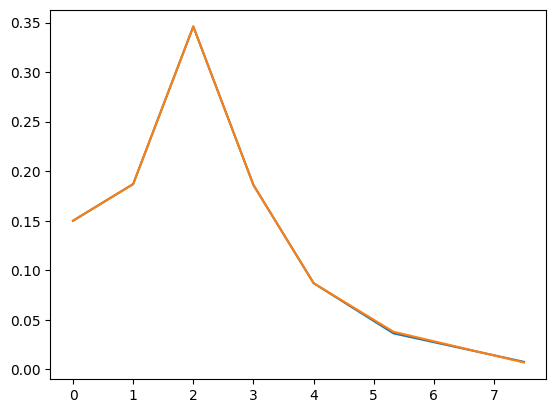

In [43]:
plot_fit(row)

## Family Size

Every other year, as part of the Current Population Survey (CPS), the Census Bureau surveys a representative sample women in the United States and asks, among other things, how many children they have ever born.
To measure completed family sizes, they select women aged 40-44 (of course, some women bear children in their forties, so these estimates might be a little low).

I used their data from 2018 to estimate the current distribution of family sizes.
The following figure shows the result.

In [44]:
def bias_pmf(pmf):
    """Compute the length-biased PMF.
    
    pmf: Pmf
    
    returns: Pmf
    """
    ps = pmf.ps * pmf.qs
    biased = Pmf(ps, pmf.qs)
    biased.normalize()
    return biased

In [45]:
row = rows.loc[2018]
model = fit_row(row)
model.mean()

2.0360000024952996

In [46]:
biased = bias_pmf(model)
biased.mean()

3.0017397260995224

In [47]:
def plot_percent(series, **options):
    """Plot a PMF as percentages."""
    (series * 100).plot(alpha=0.4, **options)

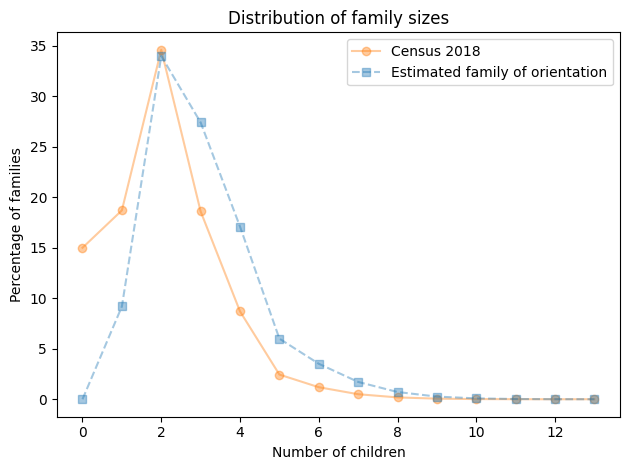

In [48]:
from utils import decorate

plot_percent(model, marker="o", color="C1", label="Census 2018")
plot_percent(
    biased, marker="s", color="C0", ls="--", label="Estimated family of orientation"
)

decorate(
    xlabel="Number of children",
    ylabel="Percentage of families",
    title="Distribution of family sizes",
)

The circles show the percentage of women who bore each number of children.
For example, about 15% of the women in the sample had no children; almost 35% of them had two.

If we take the distribution of family size from a sample of women, multiply each bar by the corresponding value of $k$, and then divide through by the total, the result is the distribution of family size from a sample of children.
In the previous figure, the square markers show this distribution.

As expected, children would report more large families (three or more children), fewer families with one child, and no families with zero children. 

In general, the average family size is smaller if we survey women than if we survey their children.
In this example, the average reported by women is close to 2; the average reported by their children would be close to 3.

## The Depression and the Baby Boom

Preston used data from the U.S. Census Bureau to compare family sizes at several points between 1890 and 1970.
Among the results, he finds:

* In 1950, the average family size reported by the women in the survey was 2.3. In 1970, it was 2.7. This increase was not surprising because the first group did most of their childbearing during the Great Depression, the second group mostly during the Baby Boom.

* However, if we survey the children of these women, and ask about their mothers, the average in the 1950 sample would be 4.9; in the 1970 sample it would be 4.5. This decrease was surprising.

According to the women in the survey, families got bigger between 1950 and 1970, by almost half a child.
According to their children, families got smaller during the same interval, by almost half a child.

Preston's paper presents the distributions in a figure, so I used a graph digitizing tool to extract them numerically.
Because this process introduces small errors, I adjusted the results to match the average family sizes Preston computed.
The following figure shows these distributions.

In [49]:
download(
    "https://github.com/AllenDowney/ProbablyOverthinkingIt/raw/book/data/preston_data.csv"
)

In [50]:
# When I made this dataset, I didn't change the default labels for the columns.

df = pd.read_csv("preston_data.csv", skiprows=1)
df

,X,Y,X.1,Y.1
0,-0.048717,0.270525,-0.025345,0.154177
1,0.995326,0.173150,0.988026,0.134487
2,2.000930,0.192124,1.960587,0.242959
3,3.008009,0.128759,2.980574,0.190334
4,3.997074,0.080072,3.989164,0.119451
5,4.998472,0.044988,4.979379,0.065036
6,5.995842,0.029952,5.979842,0.034606
7,6.992782,0.017064,6.992206,0.019928
8,8.003205,0.012053,7.988714,0.009189
9,8.983352,0.007757,8.998418,0.007757


In [51]:
# Y contains the PMF values from 1950

pmf1950 = Pmf(df["Y"]).copy()
pmf1950.sum()

0.967064439140811

In [52]:
# Y.1 contains the PMF values from 1970

pmf1970 = Pmf(df["Y.1"]).copy()
pmf1970.sum()

0.9881861575178994

Here's what the raw data look like.

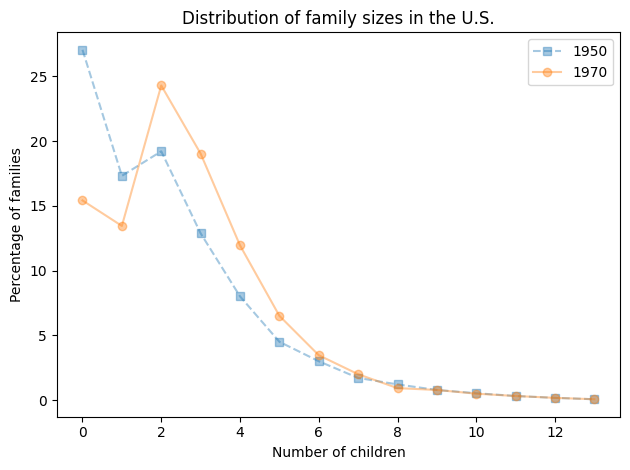

In [53]:
plot_percent(pmf1950, label="1950", marker="s", ls="--")
plot_percent(pmf1970, label="1970", marker="o")

decorate(
    xlabel="Number of children",
    ylabel="Percentage of families",
    title="Distribution of family sizes in the U.S.",
)

The data past x=6 are not very accurate, and the PMFs are not normalized.

However, we also have the means of X and C to help us adjust the PMFs.

The following function takes mu, which is the Poisson parameter of the tail, and scale, which is the normalizing constant for the actual data, and returns a normalized PMF.

In [54]:
def make_model2(mu, scale, pmf):
    """Add a Poisson tail to a given dataset.
    
    mu: mean
    scale: multiplier
    pmf: given distribution
    
    returns: Pmf
    """
    actual = pmf[:8] * scale

    model = make_poisson(mu)
    model[:8] = 0
    model.normalize()
    model *= 1 - actual.sum()
    model[:8] = actual
    return model

Now the job is to estimate the parameters to best fit the data.
As a starting place, `(8, 1)` does ok.

In [55]:
model = make_model2(8, 1, pmf1950)
model.sum()

1.0

<Axes: >

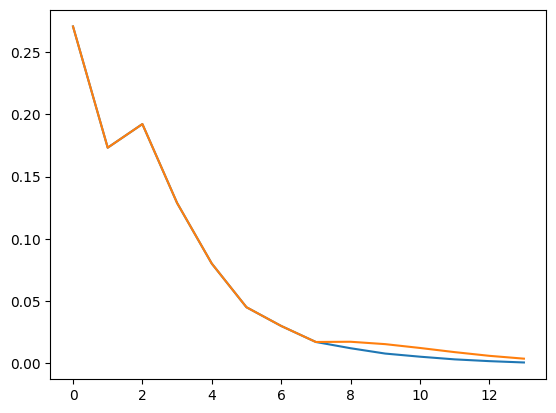

In [56]:
pmf1950.plot()
model.plot()

But we can use `least_squares` to improve it. Here's the error function.

In [57]:
def error_func2(params, pmf, stats):
    """Error function for fitting a model.
        
    params: mu and scale
    pmf: Pmf
    stats: the mean of X and C
    """
    mu, scale = params
    model = make_model2(mu, scale, pmf)
    error1 = model.mean() - stats[0]
    biased = bias_pmf(model)
    error2 = biased.mean() - stats[1]
    return error1, error2

Here are the stats from 1950.

In [58]:
params = [8, 1]
stats = 2.292, 4.909
error_func2(params, pmf1950, stats)

(0.11168500538590553, 0.3107205927152643)

The following function find the best fit and returns a `Pmf`.

In [59]:
def fit_pmf2(pmf, stats):
    """Find a model that reproduces the published summary stats.

    pmf: given data
    stats: mean of X and C
    
    returns: Pmf
    """
    params = [8, 1]
    res = least_squares(error_func2, x0=params, args=(pmf, stats))

    mu, scale = res.x
    print("best", mu, scale)
    model = make_model2(mu, scale, pmf)
    return model

In [60]:
model1950 = fit_pmf2(pmf1950, stats)

best 7.918333883292639 1.015117690621446


The means of C and X and just about right.

In [61]:
biased = bias_pmf(model1950)
model1950.mean(), biased.mean(), stats

(2.2919999999999994, 4.909000000000001, (2.292, 4.909))

And the agreement looks good enough.

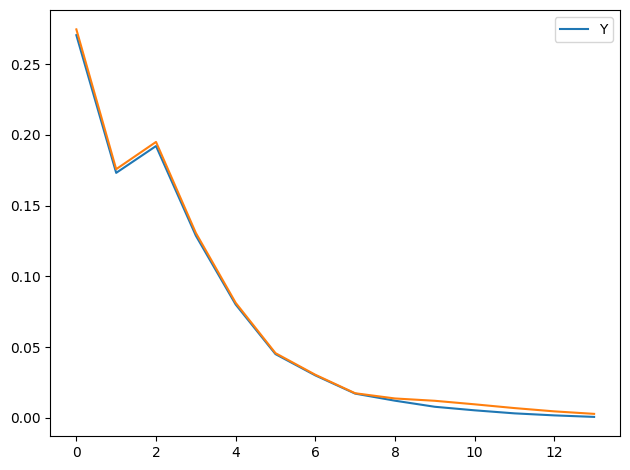

In [62]:
pmf1950.plot()
model1950.plot()
decorate()

Here's the model for the 1970 data.

In [63]:
stats = 2.705, 4.461
model1970 = fit_pmf2(pmf1970, stats)

best 6.92744420810399 1.0005469812609125


In [64]:
biased = bias_pmf(model1970)
model1970.mean(), biased.mean(), stats

(2.7050000000000565, 4.460999999999886, (2.705, 4.461))

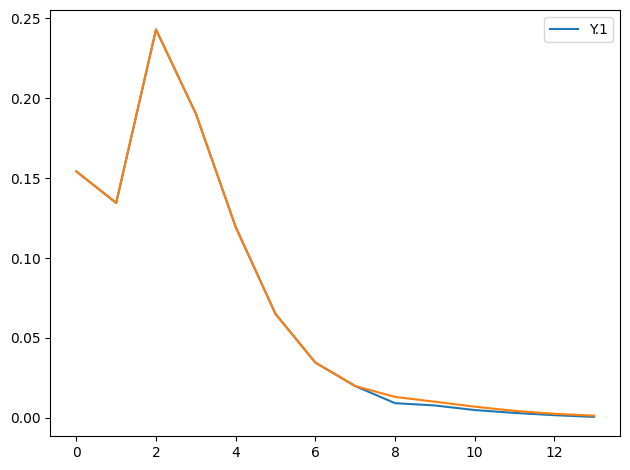

In [65]:
pmf1970.plot()
model1970.plot()
decorate()

Here are the two models.

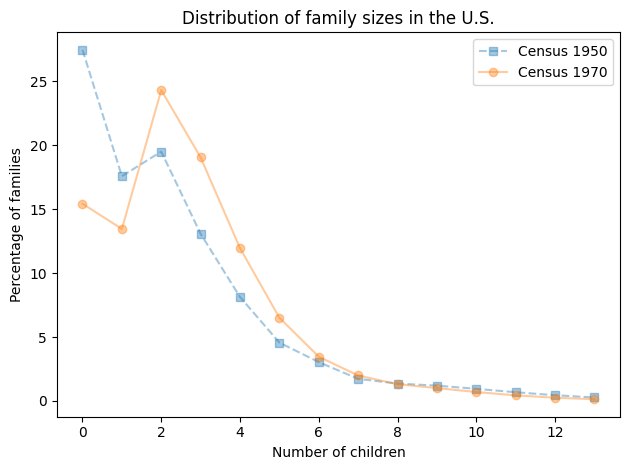

In [66]:
plot_percent(model1950, label="Census 1950", marker="s", ls="--")
plot_percent(model1970, label="Census 1970", marker="o")

decorate(
    xlabel="Number of children",
    ylabel="Percentage of families",
    title="Distribution of family sizes in the U.S.",
)

Family size was more variable in the 1950 cohort. 
The standard deviation of the distribution was about 2.4; in the 1970 cohort it was about 2.2.
This variability is the reason for the difference between the two ways of measuring family size.

As Preston derived, there is a mathematical relationship between the average family size as reported by women, which he calls $X$, and the average family size as reported by their children, which he calls $C$.

$C = X + V/X$

where $V$ is the variance of the distribution (the square of standard deviation).

Compared to 1950, $X$ was bigger in 1970, but $V$ was smaller; and as it turns out, $C$ was smaller, too.
That's how family sizes can be bigger if we survey mothers and smaller if we survey their children.

In [67]:
pmf1950[0], model1950[0]

(0.2705250596658711, 0.27461477382324795)

In [68]:
pmf1970[0], model1970[0]

(0.1541766109785203, 0.15426094269559656)

In [69]:
model1950.std(), model1970.std()

(2.4491149421780922, 2.179444883450747)

In [70]:
X = model1950.mean()
C = X + model1950.var() / X
X, C

(2.2919999999999994, 4.909)

In [71]:
X = model1970.mean()
C = X + model1970.var() / X
X, C

(2.7050000000000565, 4.460999999999887)

## More Recently

With more recent Census data, we can see what has happened to family sizes since 1970.

In [72]:
from utils import make_lowess, plot_series_lowess

The following figure shows the average number of children born to women aged 40-44 when they were surveyed.
The first cohort was interviewed in 1976, the last in 2018.

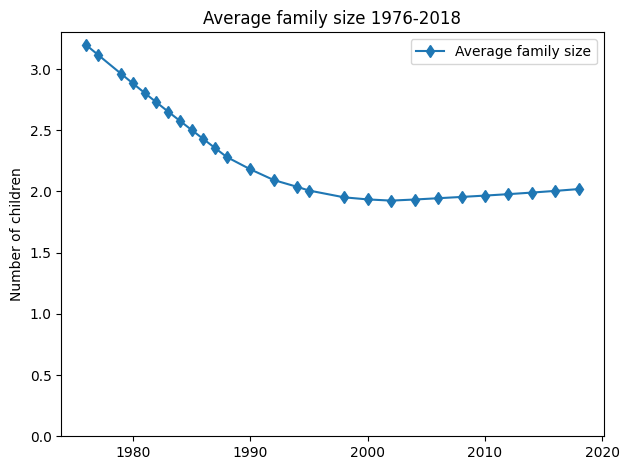

In [73]:
plot_series_lowess(
    rows["Rate per 1000"] / 1000, label="Average family size", marker="d"
)

decorate(
    ylabel="Number of children", title="Average family size 1976-2018", ylim=[0, 3.3]
)

Between 1976 and 1990, average family size fell from more than 3 to less than 2.
Since 2010, it has increased a little.

To see where those changes came from, let's see how each part of the distribution has changed.
The following figure shows the percentage of women with 0, 1, or 2 children, plotted over time.

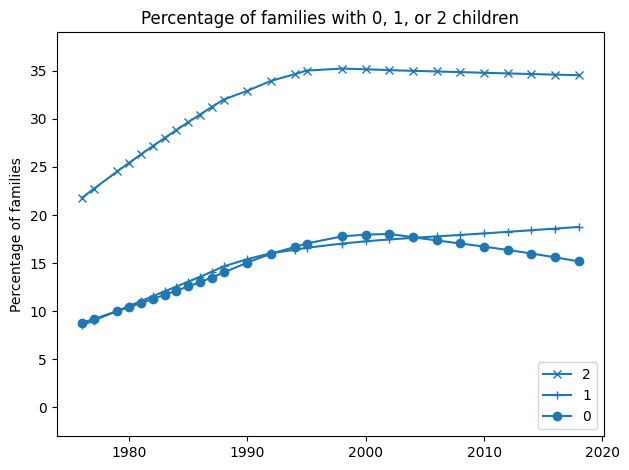

In [74]:
plot_series_lowess(rows["Two"], label="2", marker="x")
plot_series_lowess(rows["One"], label="1", marker="+")
plot_series_lowess(rows["None"], label="0", marker="o")

decorate(
    ylabel="Percentage of families",
    title="Percentage of families with 0, 1, or 2 children",
    ylim=[-3, 39],
    loc="lower right",
)

The fraction of small families has increased; most notably, between 1976 and 1990, the percentage of women with two children increased from 22% to 35%.
The percentage of women with one child or zero also increased.

The following figure shows how the percentage of large families changed over the same period.

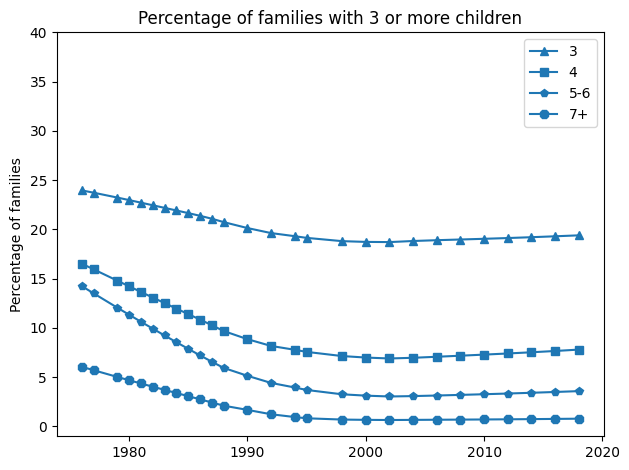

In [75]:
plot_series_lowess(rows["Three"], label="3", marker="^")
plot_series_lowess(rows["Four"], label="4", marker="s")
plot_series_lowess(rows["Five and six"], label="5-6", marker="p")
plot_series_lowess(rows["Seven or more"], label="7+", marker="8")

decorate(
    ylabel="Percentage of families",
    title="Percentage of families with 3 or more children",
    ylim=[-1, 40],
)

The proportion of large families declined substantially, especially the percentage of families with 5-6 children, which was 14% in 1976 and 4% in 2018.
Over the same period, the percentage of families with seven or more children declined from 6% to less than 1%.

We can use this data to see how the two measures of family size have changed over time.

The following figure shows $X$, which is the average number of children ever born to the women who were surveyed, and $C$, which is the average we would measure if we surveyed their children.

In [76]:
for year in [1976, 1990, 1998, 2008, 2018]:
    row = rows.loc[year]
    model = fit_row(row)
    biased = bias_pmf(model)
    X = model.mean()
    C = biased.mean()
    print(year, X, C, C - X, row["Rate per 1000"])

1976 3.0910000000007147 4.433126835158552 1.342126835157837 3091
1990 2.045000038403182 3.055184644518847 1.010184606115665 2045
1998 1.8770000809557768 2.8402939128993694 0.9632938319435926 1877
2008 1.9010000215051315 2.8941684703733275 0.993168448868196 1901
2018 2.0360000024952996 3.0017397260995224 0.9657397236042229 2036


In [77]:
x_series = pd.Series(index=rows.index, dtype=float)
c_series = pd.Series(index=rows.index, dtype=float)

for year, row in rows.iterrows():
    model = fit_row(row)
    biased = bias_pmf(model)
    x_series[year] = model.mean()
    c_series[year] = biased.mean()

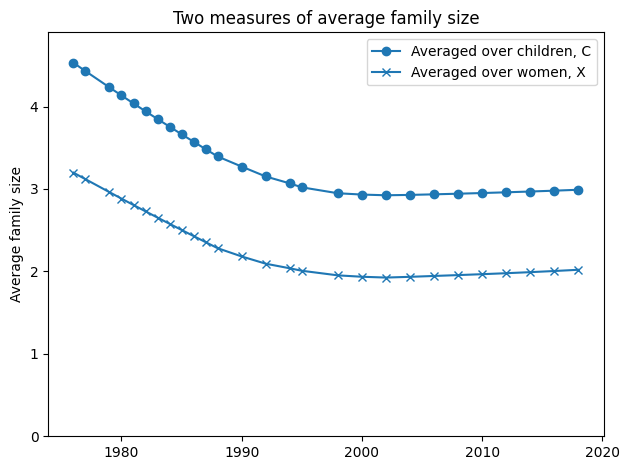

In [78]:
plot_series_lowess(c_series, label="Averaged over children, C", marker="o")
plot_series_lowess(x_series, label="Averaged over women, X", marker="x")

decorate(
    ylabel="Average family size",
    title="Two measures of average family size",
    ylim=[0, 4.9],
)

Between 1976 and 1990, the average family size reported by women, $X$, decreased from 3.1 to 2.0.
Over the same period, the average family size reported by children, $C$, decreased from 4.4 to 2.8.
Since 1990, $X$ has been close to 2 and $C$ has been close to 3.

## Preston's Paradox

Now we are ready to explain the surprising result from the imaginary kingdom at the beginning of the chapter.


But using the actual distribution from 1970 as a starting place, we can simulate what would have happened in different scenarios.

First, let's suppose that every woman has the same number of children as her mother.
As a small example, suppose there are only two families, one with two children and the other with four, so the average family size is three.

Assuming that half of the children are girls, in the next generation there would be one woman from a two-child family and two children from a four-child family.

In [79]:
pmf = Pmf.from_seq([2, 4])
pmf.mean()

3.0

In [80]:
biased = bias_pmf(pmf)
biased.mean()

3.333333333333333

In [81]:
biased2 = bias_pmf(biased)
biased2.mean()

3.6

In [82]:
row = rows.loc[1979 + 25]
model = fit_row(row)
model.mean()

1.8950000219673087

In [83]:
row = rows.loc[1979]
model = fit_row(row)
model.mean()

2.9960000001442606

In [84]:
biased = bias_pmf(model)
biased.mean()

4.25534466920534

If each of these women has the same number of children as her mother, one would have two children and the other two would have four.
So the average family size would be 3.33.

In the next generation, there would be one woman with two children, again, but there would be four with four. So the average family size would be 3.6.

In successive generations, the number of four-child families would increase exponentially, and the average family size would quickly approach to 4.

We can do the same calculation with a more realistic distribution.
The following figure shows the actual distribution of family sizes from 1979 (solid line) and the result of this calculation, which simulates the "same as mother" scenario (dashed line).

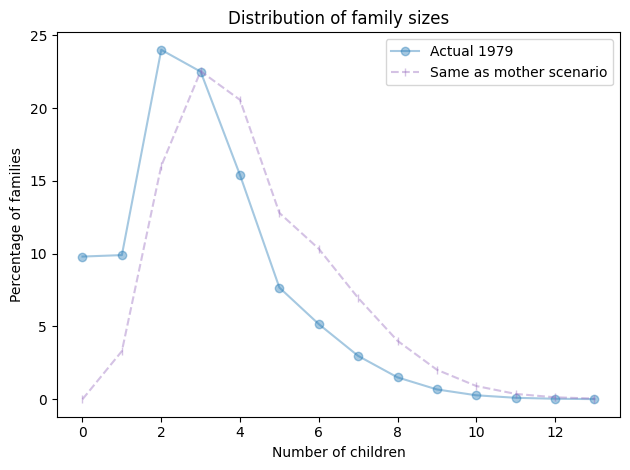

In [85]:
plot_percent(model, label="Actual 1979", marker="o")
plot_percent(biased, label="Same as mother scenario", ls="--", marker="|", color="C4")

decorate(
    xlabel="Number of children",
    ylabel="Percentage of families",
    title="Distribution of family sizes",
)

The mean of the original distribution is 3; the mean of the simulated distribution is 4.3.

If we repeat the process, the average family size would be 5.2 in the next generation, 6.1 in the next, and 6.9 in the next.
Eventually, nearly all women would have 13 children, which is the maximum in this dataset.

In [86]:
for i in range(2, 6):
    biased = bias_pmf(biased)
    print(i, biased.mean())

2 5.205672599164491
3 6.10968948800601
4 6.924225284367675
5 7.637134370388916


The following simulations are intended to confirm that the results we just computed are correct.

In [87]:
def simulate(sample, p=0):
    """Simulate the same as mother or one less models.
    
    sample: sample of family sizes
    p: probability of having one child less than, or the same as, one's mother
    
    returns: sample of next generation
    """
    res = []
    for k in sample:
        if k == 0:
            continue
        children = np.random.choice([k - 1, k], size=k, p=[p, 1 - p])
        res.extend(children)

    # return a random sample of half of the children
    index = np.where(np.random.choice(2, size=len(res)))
    return np.array(res)[index]

Generate a sample from the model to start.

In [88]:
gen0 = model.sample(10000).astype(int)
gen0.mean()

2.964

Simulate the next generation.

In [89]:
gen1 = simulate(gen0, p=0)
gen1.mean()

4.1827000808407435

Compare the simulation results to the biased model.

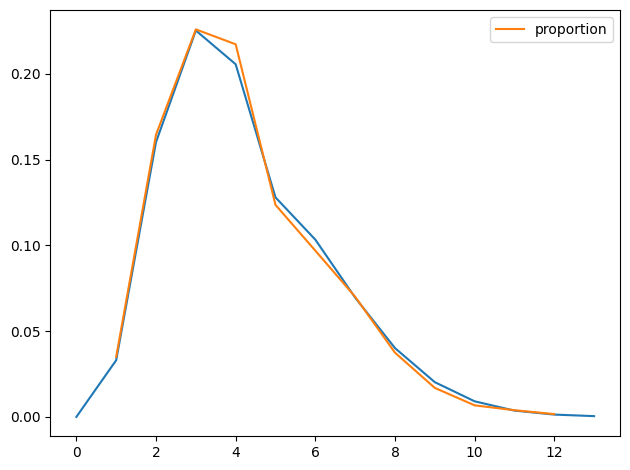

In [90]:
biased = bias_pmf(model)
biased.plot()
Pmf.from_seq(gen1).plot()
decorate()

## One Child Fewer

Suppose every woman has precisely one child fewer than her mother.
We can simulate this behavior by computing the biased distribution, as in the previous section, and then shifting the result one child to the left.

The following figure shows the actual distribution from 1979 again, along with the result of this simulation.

In [91]:
def shift_pmf(pmf):
    """Shift the values to the left by one.
    
    pmf: Pmf
    
    returns: Pmf
    """
    qs = pmf.qs[:-1]
    ps = pmf.ps[1:]
    return Pmf(ps, qs)

In [92]:
row = rows.loc[1979]
model = fit_row(row)
model.mean()

2.9960000001442606

In [93]:
biased = bias_pmf(model)
biased.mean()

4.25534466920534

In [94]:
shifted = shift_pmf(biased)
shifted.mean()

3.25534466920534

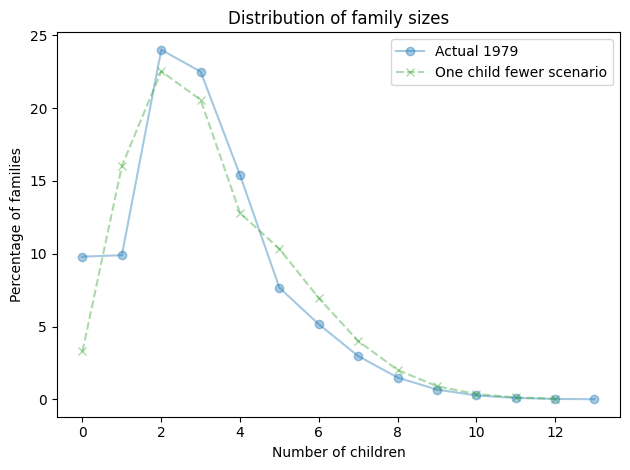

In [95]:
plot_percent(model, label="Actual 1979", marker="o")
plot_percent(shifted, label="One child fewer scenario", ls="--", marker="x", color="C2")

decorate(
    xlabel="Number of children",
    ylabel="Percentage of families",
    title="Distribution of family sizes",
)

The simulated distribution has been length-biased, which increases the average, and then shifted to the left, which decreases the average.
In general, the net effect could be an increase or a decrease;
in this example, it's an increase from 3.0 to 3.3.

## In The Long Run

If we repeat this process and simulate the next generation, the average family size increases again, to 3.5. In the next generation it increases to 3.8.

It might seem like it would increase forever, but if every woman has one child fewer than her mother, in each generation the *maximum* family size decreases by one.
So eventually the *average* comes down.

The following figure shows the average family size over 10 generations, where Generation 0 follows the actual distribution from 1979.

In [96]:
sizes = pd.Series([], dtype=float)
sizes[0] = model.mean()
shifted = model.copy()

for i in range(1, 10):
    shifted = shift_pmf(bias_pmf(shifted))
    sizes[i] = shifted.mean()

sizes

0    2.996000
1    3.255345
2    3.497601
3    3.797560
4    3.937929
5    3.910277
6    3.776723
7    3.553760
8    3.220451
9    2.768708
dtype: float64

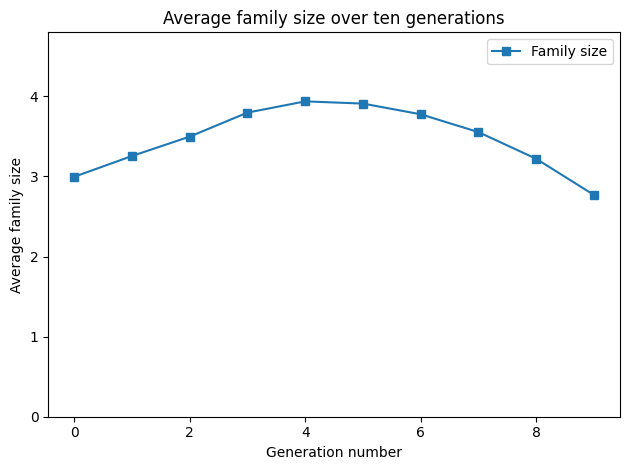

In [97]:
sizes.plot(label='Family size', marker='s')

decorate(xlabel='Generation number',
         ylabel='Average family size',
         ylim=[0, 4.8],
         title='Average family size over ten generations')


Family size would increase for four generations, peaking at 3.9.
Then it would take another five generations to fall below the starting value.

## In Reality

The average family size, as seen by the children of the women surveyed in 1979, was 4.3.
But when those children grew up and the women among them were surveyed in 1990, they reported an average family size close to 2.
So on average, they had 2.3 fewer children than their mothers.

The following function simulates a generation where each woman has 2-3 children fewer than her mother.

In [98]:
def simulate3(sample, p=0):
    """Simulate a scenario where people have 2-3 children less than their mother did.
    
    sample: sample of family sizes
    p: probability of having three less than one's mother
    
    returns: sample of next generation
    """
    res = []
    everybody = []

    for k in sample:
        if k == 0:
            continue

        everybody.extend([k] * k)
        if k < 3:
            children = [0] * k
        else:
            children = np.random.choice([k - 3, k - 2], size=k, p=[p, 1 - p])
        res.extend(children)

    everybody = np.array(everybody)
    res = np.array(res)
    diff = everybody - res
    print(everybody.mean(), res.mean(), diff.mean())
    
    # return a randomly-chosen half of the children
    index = np.where(np.random.choice(2, size=len(res)))
    return res[index]

In [99]:
sample = [0, 1, 2, 3]
simulate3(sample, 0)

2.3333333333333335 0.5 1.8333333333333333


array([0])

In [100]:
row = rows.loc[1979]
model = fit_row(row)
model.mean()

2.9960000001442606

In [101]:
biased = bias_pmf(model)
biased.mean()

4.25534466920534

In [102]:
sample = model.sample(10000).astype(int)
sample.mean()

2.973

By adjusting the parameter `p`, we can find a simulation that roughly reproduces the changes in fertility between 1979 and 1990.

In [103]:
gen1 = simulate3(sample, p=0.33)
gen1.mean()

4.237672384796502 2.003363605785402 2.2343087790111


2.0061907004912185

## In the Present

The women surveyed in 1990 had 2.3 fewer children than their mothers, on average.
If that pattern had continued for another generation, the average family size in 2018 would have been about 0.8.

In [104]:
row = rows.loc[1990]
model = fit_row(row)
model.mean()

2.045000038403182

In [105]:
sample = model.sample(10000).astype(int)
sample.mean()

2.0441

In [106]:
gen1 = simulate3(sample, p=0.6)
gen1.mean()

3.0621300327772616 0.8037767232522871 2.258353309524974


0.8013968129057644

In fact, the average family size in 2018 was very close to 2; this is close to what we would expect if every woman had one child fewer than her mother.
The following distribution shows the actual distribution in 2018, compared to the result if we start with the 1990 distribution and simulate the "one child fewer" scenario.

In [107]:
row = rows.loc[1990]
model1990 = fit_row(row)
model1990.mean()

2.045000038403182

In [108]:
shifted = shift_pmf(bias_pmf(model1990))
shifted.mean()

2.055184644518847

In [109]:
row = rows.loc[2018]
model2018 = fit_row(row)
model2018.mean()

2.0360000024952996

In [110]:
def make_pmf_from_model(model):
    """Make a Pmf with the same index as the data.
    
    model: Pmf with a complete tail
    
    returns: Pmf
    """
    index = [0, 1, 2, 3, 4, "5-6", "7+"]
    ps = model[0:7].copy().values
    ps[5] += ps[6]
    ps[6] = model[7:].sum()
    return Pmf(ps, index)

In [111]:
def make_pmf_from_row(row):
    """Make a Pmf from a row of data.
    
    row: Series
    
    returns: Pmf
    """
    actual = row.iloc[3:10].astype(float) / 100
    index = [0, 1, 2, 3, 4, "5-6", "7+"]
    pmf = Pmf(actual.values, index)
    return pmf

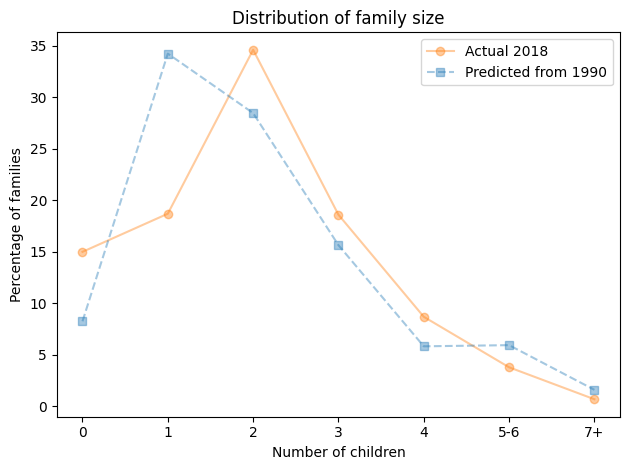

In [112]:
row = rows.loc[2018]
pmf = make_pmf_from_row(row)
plot_percent(pmf, label="Actual 2018", color="C1", marker="o")

pmf = make_pmf_from_model(shifted)
plot_percent(pmf, label="Predicted from 1990", marker="s", ls="--")

decorate(
    xlabel="Number of children",
    ylabel="Percentage of families",
    title="Distribution of family size",
)

The means of the two distributions are almost the same, but the shapes are different.
But at least on average, it seems like women in the U.S. have been following the "one child fewer" policy for the last 30 years.

## Technical Note: The Poisson distribution

Suppose every year, for 20 years, you roll a 10-sided die, and every year, if you roll a 10, you have a baby.
On average, you would have a total of two babies.
But as the dice fall, you might have more or fewer.
Across the population, what would the distribution of family size look like?

Under these assumptions, it would follow the Poisson distribution, named after French mathematician Siméon Denis Poisson, who wrote about it in 1837, modeling the number of wrongful criminal convictions per year.

The Poisson distribution is relevant to Preston's Paradox for two reasons:

* Since 1990, the distribution of family size in the U.S. has come to resemble a Poisson distribution.

* Under the "one child fewer" policy, the Poisson distribution is completely unchanged from one generation to the next.

The following figure demonstrates the first point.

In [113]:
def make_pmf_from_poisson(mu):
    """Make a Poisson distribution and summarize it.
    
    mu: mean of the distribution
    
    returns: Pmf
    """
    index = [0, 1, 2, 3, 4, "5-6", "7+"]
    ps = poisson.pmf([0, 1, 2, 3, 4, 5, 6], mu)
    ps[5] += ps[6]
    ps[6] = poisson.sf(6, mu)
    return Pmf(ps, index)

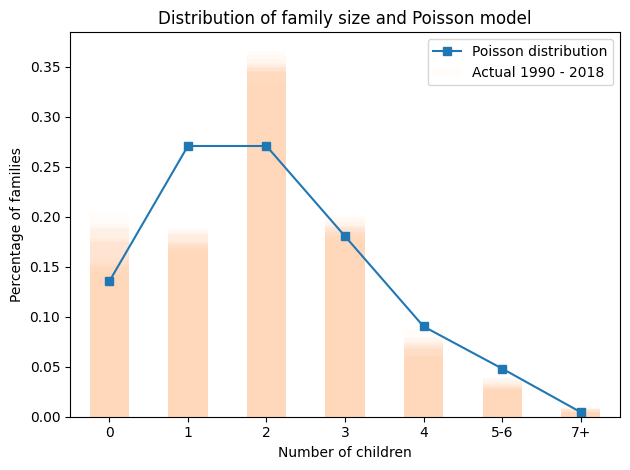

In [114]:
for year in rows.index[:15]:
    pmf = make_pmf_from_row(rows.loc[year])
    label = "Actual 1990 - 2018" if year == 2018 else ""
    pmf.plot.bar(label=label, color="C1", alpha=0.02)

pmf = make_pmf_from_poisson(2)
pmf.plot(label="Poisson distribution", marker="s")

decorate(
    xlabel="Number of children",
    ylabel="Percentage of families",
    title="Distribution of family size and Poisson model",
)

The bars show the actual distributions for selected years from 1990 to 2018, with the shaded areas representing variation from year to year.
The line shows a Poisson distribution with an average value of 2, which is close to the actual average during this interval.

In reality, there are more zero- and two-child families than we would expect from a Poisson distribution, and fewer one-child families.
But given the complexities of childbearing, it is surprising that the simple dice-rolling model does as well as this.

Now suppose that the family sizes actually follow a Poisson distribution, and let's see what happens in the "one child fewer" scenario.
The following figure shows three distributions:

* A Poisson distribution with mean 2, plotted with bars, 

* The biased distribution of family size we would see if we surveyed children, plotted with a dashed line, and

* The distribution of family size those children would have under the "one child fewer" policy, plotted with a dotted line.

In [115]:
model = make_poisson(2)
model.mean()

1.9999996439174659

In [116]:
biased = bias_pmf(model)
biased.mean()

2.999997685463117

In [117]:
shifted = shift_pmf(biased)
shifted.mean()

1.999997685463117

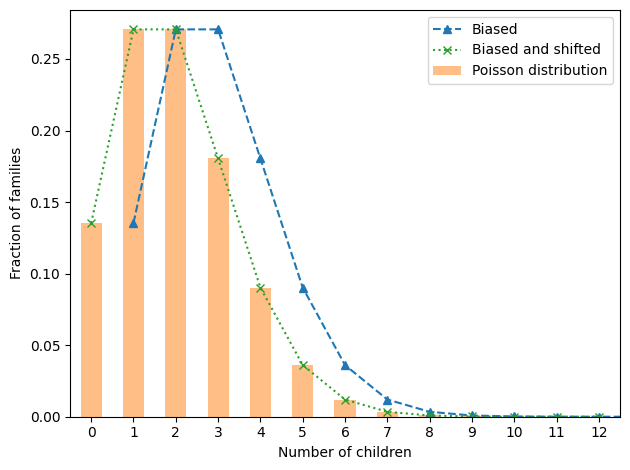

In [118]:
model[:13].plot.bar(label="Poisson distribution", color="C1", alpha=0.5)
biased[1:].plot(label="Biased", ls="--", marker="^")
shifted.plot(label="Biased and shifted", color="C2", ls=":", marker="x")

decorate(xlabel="Number of children", ylabel="Fraction of families", title="")

The biased distribution is identical to the original distribution, but shifted to the right by one.
When we apply the "one child fewer" policy, it shifts the distribution to the left by one, right back where it started.

Probably Overthinking It

Copyright 2022 Allen Downey 

The code in this notebook and `utils.py` is under the [MIT license](https://mit-license.org/).